In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from pymc3.ode import DifferentialEquation
from scipy.integrate import solve_ivp
import arviz as az
from pymc3 import traceplot
from pymc3.distributions import Interpolated
from scipy import stats
import matplotlib as mpl
import time

import warnings
warnings.filterwarnings("ignore")



In [2]:
#dox_dose_days = np.array([[2, 7]])
"""
switcher={
        ('dox',1): [39],
        
        ('her',2): [35,38],
        
        ('dox',3): [35],
        ('her',3): [36,39],
        
        ('her',4): [35,38],
        ('dox',4): [39],
        
        ('her',5): [35,38],
        ('dox',5): [35,38]
    }  
"""

print('')

In [3]:
path_to_data = "C:/Users/rwyde/Desktop/trazdox/data/filtered_data_csv.csv"
data = pd.read_csv(path_to_data)
data.head()


,Day,G1_avg,G1_sd,G2_avg,G2_sd,G3_avg,G3_sd,G4_avg,G4_sd,G5_avg,G5_sd,G6_avg,G6_sd
0,7,51.786507,20.212286,31.930893,16.927490,48.806049,19.286955,43.664264,19.417161,30.988742,17.752230,44.409795,13.040341
1,14,66.185535,27.352276,53.804666,21.294581,69.038249,35.959695,46.313592,27.260107,34.640653,25.398323,60.142226,16.147825
2,23,100.841313,48.551059,67.105632,29.538706,126.046100,42.178934,85.785176,68.526077,61.905680,33.892752,135.849364,62.744238
3,29,205.291993,85.584746,141.023314,53.179914,241.478202,111.850683,251.086596,140.093869,134.994293,65.107710,207.222552,91.554513
4,34,334.876240,106.083280,225.843888,92.229404,393.011416,100.606232,443.482321,223.956685,257.324806,123.482982,303.385114,117.382875


In [4]:
data_array = data.to_numpy()
days = data_array[:,0]
tumor_sizes = data_array[:,1::2]
tumor_sigmas = data_array[:,2::2]

In [5]:
print(tumor_sizes.shape)

(19, 6)


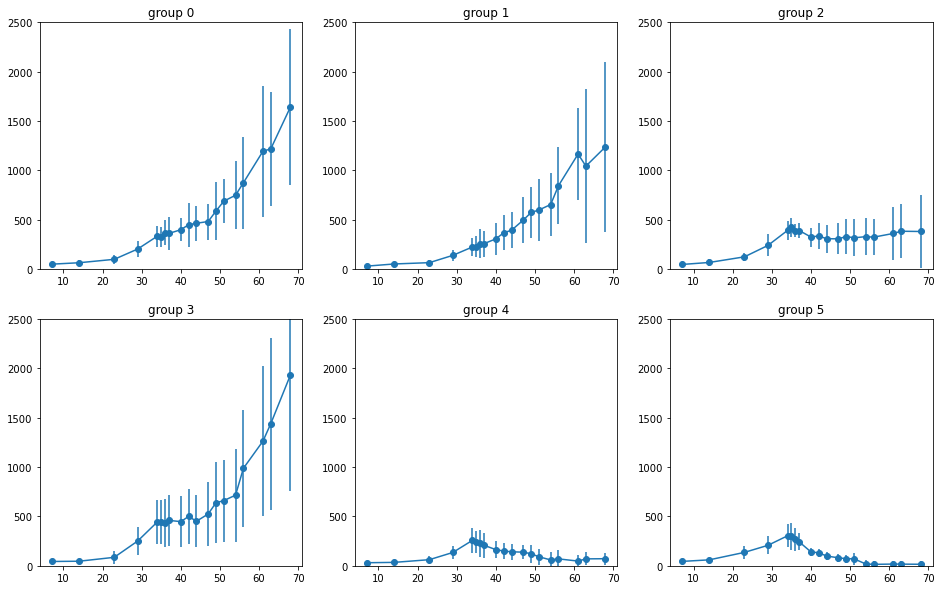

In [6]:
plt.figure(figsize=(16,10))
for ii in range(6):
    plt.subplot(2,3,ii+1)
    plt.ylim(0,2500)
    plt.scatter(days, tumor_sizes[:,ii])
    plt.errorbar(days, tumor_sizes[:,ii], tumor_sigmas[:,ii])
    plt.title("group {}".format(ii))
plt.show()

In [7]:
eps = 1e-2
y0 = np.array(tumor_sizes[0,0:2])

    
def stiff_de(t, y, p):
    r = p[0]
    return [y[0]*r,y[1]*r]

#wrap the function to change the arguments order, so we can pass it to DifferentialEquation
def stiff_de_wrap(y, t, p):
    return stiff_de(t, y, p)

ode_model = DifferentialEquation(
    func = stiff_de_wrap,
    times=days,
    n_states=2,
    n_theta=1,
    t0=7,    
)



num_samples = 200
num_chains = 2
tune_frac = 0.2

sampling priors
plotting prior samples


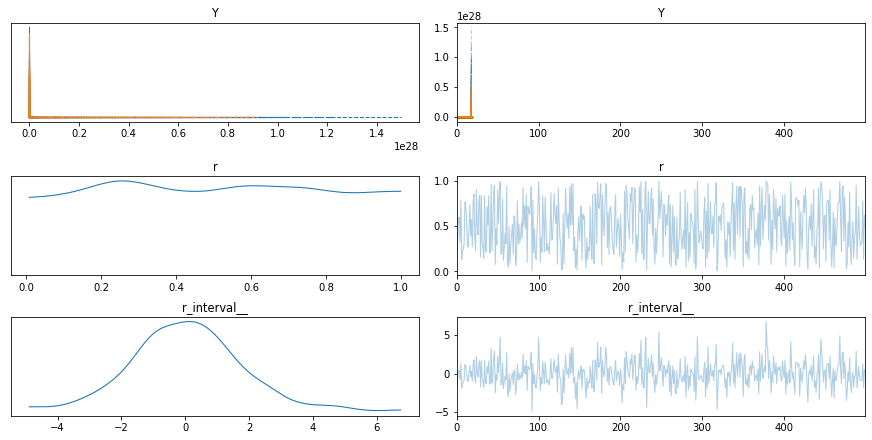

Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [r]


running MCMC


Sampling 2 chains for 40 tune and 200 draw iterations (80 + 400 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


plotting MCMC trace


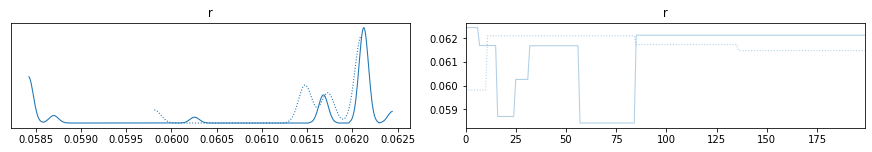

22.524298906326294 seconds
sampling posteriors


plotting posterior samples


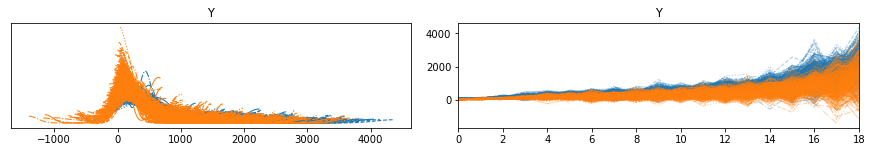

11.95012092590332 seconds
generating posterior distributions
plotting posterior distribution


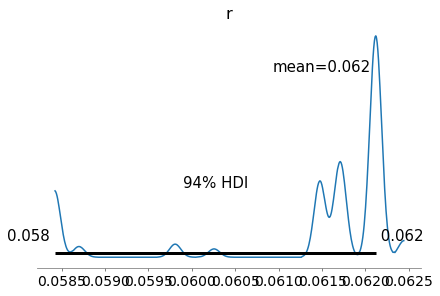

4.0116963386535645 seconds
(6302,)
(2, 6302)


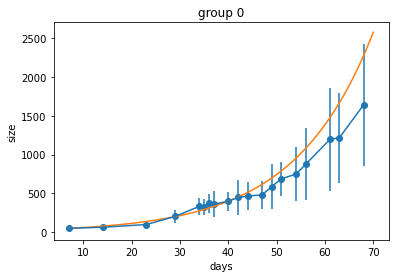

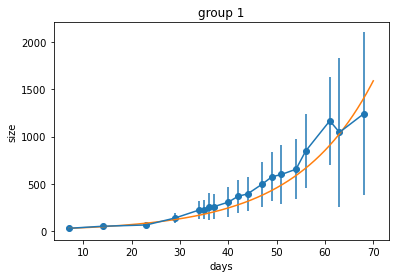

In [8]:

with pm.Model() as model:
    # Specify prior distributions for soem of our model parameters
    #dose = pm.Uniform('dose', 0, 100)
    r = pm.Uniform('r',0,1)
    
    # If we know one of the parameter values, we can simply pass the value.
    ode_solution = ode_model(y0=y0, theta=[r])
    
    # The ode_solution has a shape of (n_times, n_states)
    #print(ode_solution.shape)
    #print(sigma.shape)
    #print(ret['y'].shape)
    Y = pm.Normal('Y', mu=ode_solution, sigma=tumor_sigmas[:,0:2], observed=tumor_sizes[:,0:2])
    #Y = pm.Normal('Y', mu=ode_solution, sigma=np.ones_like(tumor_sizes[:,0:2]), observed=tumor_sizes[:,0:2])
    
    
    print("sampling priors")
    prior = pm.sample_prior_predictive()
    print("plotting prior samples")
    #az.plot_trace(prior)
    traceplot(prior, show=True)
    
    
    print("running MCMC")
    step = pm.Metropolis()
    t1 = time.time()
    trace = pm.sample(num_samples, tune=int(num_samples*tune_frac), chains=num_chains, cores=1, step=step)
    print("plotting MCMC trace")
    #az.plot_trace(trace)
    traceplot(trace, show=True)
    t2 = time.time()
    print(t2-t1, "seconds")
    
    
    print("sampling posteriors")
    posterior_predictive = pm.sample_posterior_predictive(trace)
    print("plotting posterior samples")
    #az.plot_trace(posterior_predictive)
    traceplot(posterior_predictive, show=True)
    t3 = time.time()
    print(t3-t2, "seconds")
    
    
    print("generating posterior distributions")
    posterior_distribution = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)
    print("plotting posterior distribution")
    az.plot_posterior(posterior_distribution, show=True)
    #traceplot(posterior_distribution)
    t4 = time.time()
    print(t4-t3, "seconds")

    
    r_mean = pm.summary(trace)['mean']['r']
    
    t_span = (7, 70)
    #ret is a dict containing the integration of the DE
    sim = solve_ivp(stiff_de, t_span, y0, method='Radau', dense_output=True, max_step=eps, args=([r_mean],))
    #sim = solve_ivp(stiff_de, days, y0, method='Radau', dense_output=False, max_step=eps, args=([r_mean],))
    t_sim = sim['t']
    y_sim = sim['y']
    
    print(t_sim.shape)
    print(y_sim.shape)
    
    plt.figure()
    plt.scatter(days, tumor_sizes[:,0])
    plt.errorbar(days, tumor_sizes[:,0], tumor_sigmas[:,0])
    plt.plot(t_sim.ravel(), y_sim[0,:])
    plt.xlabel('days')
    plt.ylabel('size')
    plt.title("group 0")
    plt.show()
    
    plt.figure()
    plt.scatter(days, tumor_sizes[:,1])
    plt.errorbar(days, tumor_sizes[:,1], tumor_sigmas[:,1])
    plt.plot(t_sim.ravel(), y_sim[1,:])
    plt.xlabel('days')
    plt.ylabel('size')
    plt.title("group 1")
    plt.show()
    
    

In [9]:

"""
# Lotka - Volterra equation
def dy_dt(y, t, r):
    return np.array([y * r])

# simulator function
def differential_model(r):
    return solve_ivp(dy_dt, y0=y0, t=days, rtol=0.01, args=(r,))


s = pm.Simulator("s", normal_sim,
                     params=(a, b),
                     sum_stat="sort",
                     epsilon=1,
                     observed=data)

trace, sim_data = pm.sample_smc(kernel="ABC",
                                            parallel=True,
                                            save_sim_data=True)
    
idata = az.from_pymc3(trace, posterior_predictive=sim_data)

trace = pm.sample_smc(num_samples, parallel=True)

https://docs.pymc.io/notebooks/SMC-ABC_Lotka-Volterra_example.html


"""

    

'\n# Lotka - Volterra equation\ndef dy_dt(y, t, r):\n    return np.array([y * r])\n\n# simulator function\ndef differential_model(r):\n    return solve_ivp(dy_dt, y0=y0, t=days, rtol=0.01, args=(r,))\n\n\ns = pm.Simulator("s", normal_sim,\n                     params=(a, b),\n                     sum_stat="sort",\n                     epsilon=1,\n                     observed=data)\n\ntrace, sim_data = pm.sample_smc(kernel="ABC",\n                                            parallel=True,\n                                            save_sim_data=True)\n    \nidata = az.from_pymc3(trace, posterior_predictive=sim_data)\n\ntrace = pm.sample_smc(num_samples, parallel=True)\n\nhttps://docs.pymc.io/notebooks/SMC-ABC_Lotka-Volterra_example.html\n\n\n'